<a href="https://colab.research.google.com/github/jahid094/Soft-Computing-Assignment-3/blob/main/170104094.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Library

In [39]:
import numpy as np
import pandas as pd
import re
import string
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [40]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [41]:
# Hyper-parameters
input_size = 50
hidden_size = 140
num_layers = 4
num_classes = 2
batch_size = 128
num_epochs = 28
learning_rate = 0.001

# Confusion Matrix

In [42]:
def plot_confusion_matrix(cm, classes):
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion matrix')
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  thresh = cm.max() / 2.
  for i in range (cm.shape[0]):
    for j in range (cm.shape[1]):
      plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
      plt.tight_layout()
      plt.ylabel('True label')
      plt.xlabel('Predicted label')

# Glove Load

In [43]:
glove = torchtext.vocab.GloVe(name="6B", dim=50, max_vectors=20000)

# Read Dataframe

In [44]:
df = pd.read_csv('/content/drive/MyDrive/soft computing assignment/Assignment 3/Dataset 2.csv', encoding = "ISO-8859-1")

# Data Preprocessing

## Stopword Remove

In [45]:
#REMOVING THE STOP WORDS
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,polarity
0,"real good moment. missssssssss much,",0
1,reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need send 'em accountant tomorrow. Odd...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...
10309,"No Depression G Herbo mood on, i'm done stress...",1
10310,What depression succumbs brain makes feel like...,1
10311,Ketamine Nasal Spray Shows Promise Against Dep...,1
10312,dont mistake bad day depression! everyone 'em!,1


## Url Remove

In [46]:
#REMOVING URL
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)
df['text'] = df['text'].apply(lambda text: remove_urls(text))
df

,text,polarity
0,"real good moment. missssssssss much,",0
1,reading manga,0
2,@comeagainjen -,0
3,@lapcat Need send 'em accountant tomorrow. Odd...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...
10309,"No Depression G Herbo mood on, i'm done stress...",1
10310,What depression succumbs brain makes feel like...,1
10311,Ketamine Nasal Spray Shows Promise Against Dep...,1
10312,dont mistake bad day depression! everyone 'em!,1


## Mention Remove

In [47]:
def remove_mention(s):
    s = re.sub(r'@[\S]+', ' ', s)
    return s
df['text'] = df['text'].apply(lambda text: remove_mention(text))
df

,text,polarity
0,"real good moment. missssssssss much,",0
1,reading manga,0
2,-,0
3,"Need send 'em accountant tomorrow. Oddly, I ...",0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...
10309,"No Depression G Herbo mood on, i'm done stress...",1
10310,What depression succumbs brain makes feel like...,1
10311,Ketamine Nasal Spray Shows Promise Against Dep...,1
10312,dont mistake bad day depression! everyone 'em!,1


## Number Remove

In [48]:
def remove_number(s):
    s = ''.join(c for c in s if not c.isdigit())
    return s
df['text'] = df['text'].apply(lambda text: remove_number(text))
df

,text,polarity
0,"real good moment. missssssssss much,",0
1,reading manga,0
2,-,0
3,"Need send 'em accountant tomorrow. Oddly, I ...",0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...
10309,"No Depression G Herbo mood on, i'm done stress...",1
10310,What depression succumbs brain makes feel like...,1
10311,Ketamine Nasal Spray Shows Promise Against Dep...,1
10312,dont mistake bad day depression! everyone 'em!,1


## Punctuation Remove

In [49]:
#REMOVING PUNCTUATIONS
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '') 
    return text
df['text'] = df['text'].apply(remove_punctuations)
df

,text,polarity
0,real good moment missssssssss much,0
1,reading manga,0
2,,0
3,Need send em accountant tomorrow Oddly I eve...,0
4,ADD ME ON MYSPACE myspacecomLookThunder,0
...,...,...
10309,No Depression G Herbo mood on im done stressin...,1
10310,What depression succumbs brain makes feel like...,1
10311,Ketamine Nasal Spray Shows Promise Against Dep...,1
10312,dont mistake bad day depression everyone em,1


## Converting Lowercase

In [50]:
#CONVERTING TO LOWERCASE
df['text'] = df['text'].str.lower()
df

,text,polarity
0,real good moment missssssssss much,0
1,reading manga,0
2,,0
3,need send em accountant tomorrow oddly i eve...,0
4,add me on myspace myspacecomlookthunder,0
...,...,...
10309,no depression g herbo mood on im done stressin...,1
10310,what depression succumbs brain makes feel like...,1
10311,ketamine nasal spray shows promise against dep...,1
10312,dont mistake bad day depression everyone em,1


## Stemming

In [51]:
#STEMMING
from nltk.stem.porter import PorterStemmer 

stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

df['text'] = df['text'].apply(lambda text: stem_words(text))
df

,text,polarity
0,real good moment missssssssss much,0
1,read manga,0
2,,0
3,need send em account tomorrow oddli i even ref...,0
4,add me on myspac myspacecomlookthund,0
...,...,...
10309,no depress g herbo mood on im done stress peop...,1
10310,what depress succumb brain make feel like neve...,1
10311,ketamin nasal spray show promis against depres...,1
10312,dont mistak bad day depress everyon em,1


## Empty Row Remove

In [52]:
df['text'].replace('', np.nan, inplace=True)

In [53]:
df

,text,polarity
0,real good moment missssssssss much,0
1,read manga,0
2,NaN,0
3,need send em account tomorrow oddli i even ref...,0
4,add me on myspac myspacecomlookthund,0
...,...,...
10309,no depress g herbo mood on im done stress peop...,1
10310,what depress succumb brain make feel like neve...,1
10311,ketamin nasal spray show promis against depres...,1
10312,dont mistak bad day depress everyon em,1


In [54]:
df.dropna(subset=['text'], inplace=True)

In [55]:
df

,text,polarity
0,real good moment missssssssss much,0
1,read manga,0
3,need send em account tomorrow oddli i even ref...,0
4,add me on myspac myspacecomlookthund,0
5,sleepi good time tonight though,0
...,...,...
10308,mani suffer depress sad feel noth all persist ...,1
10309,no depress g herbo mood on im done stress peop...,1
10310,what depress succumb brain make feel like neve...,1
10311,ketamin nasal spray show promis against depres...,1


## Tokenize text

In [56]:
def textSplit(text):
  return text.split()

In [57]:
df['text'] = df['text'].apply(textSplit)

In [58]:
df

,text,polarity
0,"[real, good, moment, missssssssss, much]",0
1,"[read, manga]",0
3,"[need, send, em, account, tomorrow, oddli, i, ...",0
4,"[add, me, on, myspac, myspacecomlookthund]",0
5,"[sleepi, good, time, tonight, though]",0
...,...,...
10308,"[mani, suffer, depress, sad, feel, noth, all, ...",1
10309,"[no, depress, g, herbo, mood, on, im, done, st...",1
10310,"[what, depress, succumb, brain, make, feel, li...",1
10311,"[ketamin, nasal, spray, show, promis, against,...",1


# Train Test Split

In [59]:
train, test = train_test_split(df,test_size=0.2, random_state=42)
train, valid = train_test_split(train,test_size=0.2, random_state=42)

# Making Loader

In [60]:
def get_text_vectors(dataframe):
  vectorList = []
  for index, row in dataframe.iterrows():
    text = row['text']
    vector_sum = sum(glove[w] for w in text)
    label = row['polarity']
    vectorList.append((vector_sum, label))
  return vectorList

In [61]:
train = get_text_vectors(train)
test = get_text_vectors(test)
valid = get_text_vectors(valid)

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

# Three Recurrent Layer LSTM

### Step #1 : Design model using class

In [62]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [63]:
'''
INSTANTIATE MODEL CLASS
'''
model = LSTM(input_size, hidden_size, num_layers, num_classes)

# To enable GPU
model.to(device)

LSTM(
  (lstm): LSTM(50, 140, num_layers=4, batch_first=True)
  (fc): Linear(in_features=140, out_features=2, bias=True)
)

### Step #2 : Construct loss and optimizer

Unlike linear regression, we do not use MSE here, we need Cross Entropy Loss to calculate our loss before we backpropagate and update our parameters.

`criterion = nn.CrossEntropyLoss() ` 

It does 2 things at the same time.

1. Computes softmax ([Logistic or Sigmoid]/softmax function)
2. Computes Cross Entropy Loss

In [64]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Step #3 : Training: forward, loss, backward, step

In [65]:
iteration_loss = []
for epoch in range(num_epochs):
  for i, (text, labels) in enumerate(train_loader):
    text = text.unsqueeze(-2).to(device)
    labels = labels.to(device)
    model.zero_grad()
    output = model(text)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
  if epoch % 5 == 4:
    # For Testing Data
    # Calculate Accuracy         
    correct = 0
    total = 0
    # Iterate through dataset
    for i, (text, labels) in enumerate(test_loader):
      text = text.unsqueeze(-2).to(device)

      # Forward pass only to get logits/output
      output = model(text)

      # Get predictions from the maximum value
      _, predicted = torch.max(output, 1)

      # Total number of labels
      total += labels.size(0)

      # Total correct predictions
      if torch.cuda.is_available():
        correct += (predicted.cpu() == labels.cpu()).sum() 
      else:
        correct += (predicted == labels).sum()

    iteration_loss.append(loss.item())
    test_accuracy = 100 * correct.item() / total
    # For Validating Data
    # Calculate Accuracy         
    correct = 0
    total = 0
    # Iterate through dataset
    for i, (text, labels) in enumerate(valid_loader):
      text = text.unsqueeze(-2).to(device)

      # Forward pass only to get logits/output
      output = model(text)

      # Get predictions from the maximum value
      _, predicted = torch.max(output, 1)

      # Total number of labels
      total += labels.size(0)

      # Total correct predictions
      if torch.cuda.is_available():
        correct += (predicted.cpu() == labels.cpu()).sum() 
      else:
        correct += (predicted == labels).sum()

    validation_accuracy = 100 * correct.item() / total
    # Print Loss
    print('Epoch: {}. Loss: {}. Testing Accuracy: {}. Validation Accuracy: {}'.format(epoch+1, iteration_loss[-1], test_accuracy, validation_accuracy))

Epoch: 5. Loss: 0.428902268409729. Testing Accuracy: 86.05442176870748. Validation Accuracy: 86.14823815309842
Epoch: 10. Loss: 0.2174958884716034. Testing Accuracy: 85.81146744412051. Validation Accuracy: 86.51275820170109
Epoch: 15. Loss: 0.22406069934368134. Testing Accuracy: 86.39455782312925. Validation Accuracy: 85.78371810449575
Epoch: 20. Loss: 0.19211891293525696. Testing Accuracy: 85.42274052478135. Validation Accuracy: 84.93317132442284
Epoch: 25. Loss: 0.09262004494667053. Testing Accuracy: 84.74246841593781. Validation Accuracy: 83.65735115431349


### Iteration Vs Loss

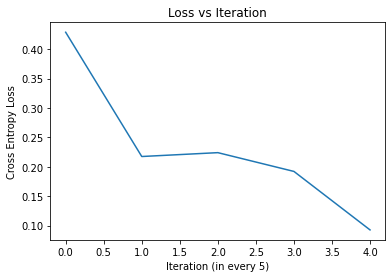

In [66]:
plt.title("Loss vs Iteration")
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 5)')
plt.show()

In [67]:
def get_all_prediction(loader):
  predictions_list = torch.tensor([], dtype=torch.int32)
  labels_list = torch.tensor([], dtype=torch.int32)
  for i, (text, labels) in enumerate(loader):
    text = text.unsqueeze(-2).to(device)

    # Forward pass only to get logits/output
    outputs = model(text)

    # Get predictions from the maximum value
    _, predictions = torch.max(outputs, 1)
    predictions_list = torch.cat((predictions_list, predictions.cpu()), dim = 0)
    labels_list = torch.cat((labels_list.cpu(), labels.cpu()), dim = 0).to(device)
  return predictions_list, labels_list.cpu()

Accuracy: 85.8115
Precision: 85.8115
Recall: 85.8115
F1 score: 85.8115


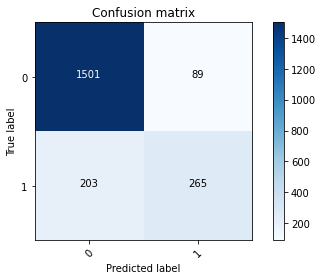

In [68]:
y_pred, y_true = get_all_prediction(test_loader)
print('Accuracy: ' +str(round(accuracy_score(y_true, y_pred) * 100, 4)))
print('Precision: ' +str(round(precision_score(y_true, y_pred, average='micro') * 100, 4)))
print('Recall: ' +str(round(recall_score(y_true, y_pred, average='micro') * 100, 4)))
print('F1 score: ' +str(round(f1_score(y_true, y_pred, average='micro')  * 100, 4)))
confusion_mtx = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(confusion_mtx, classes = range(2))

# Prediction

In [69]:
def predict_sentiment(text):
  text = sum(glove[w] for w in text)
  text = text.reshape(1, 1, 50).to(device)
  output = model(text)
  _, predicted = torch.max(output, 1)
  if predicted > 0.5:
    print('Positive sentiment')
  else:
    print('Negative sentiment')

In [70]:
test_text = input()
predict_sentiment(test_text)

he is a bad boy
Negative sentiment
